## Model Improvement Suggentions

**1:** Test different methods for each model pipeline steps

**1.1:** Try different Model
- Current Model: all-mpnet-base-v2
- [Hugging Face - Model leaderboard:](https://huggingface.co/spaces/mteb/leaderboard) (Try at least 3 best ones)

**1.2:** Try skill-by-skill vs. bag-of-skills

**1.3:** ...

**2:** Last Step: Cross-Encoder without and with special tokens (new approach)

# 1 Running the Analysis on the Baseline Model

## 1.1 Import the Synthetic Dataset (100 JDs a 6 CVs)

In [2]:
import pandas as pd

# Import the CSV file into a dataframe
file_path = "/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data.csv"
df_synth_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify the import
df_synth_data

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0
...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Smith** \n123 Tech Drive \nSan Jose, ...",1
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,**Resume**\n\n**John Doe** \n123 Main Street ...,1
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n[Your Address] \n[City, State...",0
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,"**John Doe** \n1234 Elm Street \nCityville, ...",0


## 1.2 Importing Classes and Functions

In [ ]:
# !pip install peft

In [2]:
import sys
import os
import pandas as pd
from spacy.lang.en import English
import importlib
import main
importlib.reload(main)

# Define project root paths
PROJECT_ROOT = '/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo'
SERVICES_DIR = os.path.join(PROJECT_ROOT, 'services')
RESOURCES_DIR = os.path.join(PROJECT_ROOT, 'Resources', 'data')

# Add the paths to sys.path if not already present
for module_path in [SERVICES_DIR, PROJECT_ROOT]:
    if module_path not in sys.path:
        sys.path.append(module_path)

# Import the necessary functions
from main import calc_similarity, calc_similarity_sbs, calc_similarity_sbs_all_MiniLM_L6_v2, calc_similarity_sbs_NV_Embed_v2, calc_similarity_sbs_BinGSE_MetaLlama_3_8B_Instruct, job_info_extraction, resume_extraction  # Import the necessary functions

# Define the path to your skills patterns file
skills_patterns_path = os.path.join(RESOURCES_DIR, 'skills.jsonl')

## 1.3 Setting up the Baseline Model Function

**Specs:**
- Bunch-of-Skills
- All-mpnet-base-v2

In [5]:
import time

def main_synth_df(synth_data):
    t0 = time.time()

    # Initialize an empty list to store results
    similarity_results = []

    # Iterate over each unique job description ID in the dataset
    for jd_id in synth_data['JD_ID'].unique():
        # Filter the data for the current job description
        job_data = synth_data[synth_data['JD_ID'] == jd_id]

        # Extract the job description text
        jd_text = job_data.iloc[0]['JD_text']
        df_jobs = pd.DataFrame([jd_text], columns=["raw"])
        df_jobs = job_info_extraction(df_jobs)  # Use job_info_extraction to extract job description skills
        
        # Extract resumes for this job description
        resumes = job_data[['CV_ID', 'CV_text']].copy()  # Include necessary columns
        resumes['name'] = resumes['CV_ID']  # Add a "name" column derived from CV_ID for compatibility
        resumes['raw'] = resumes['CV_text']  # Add a "raw" column for compatibility
        df_resumes = resume_extraction(resumes)  # Use resume_extraction to extract resume skills
        
        # Calculate similarity for the job description and its related resumes
        analysis_data_df = calc_similarity(df_resumes, df_jobs, parallel=True)
        
        # Add similarity scores back to the original data
        job_data = job_data.reset_index(drop=True)
        job_data['Similarity_score'] = analysis_data_df['similarity_score']  # Assuming calc_similarity outputs this

        # Append to results
        similarity_results.append(job_data)

    # Combine all results into a single DataFrame
    df_final = pd.concat(similarity_results, ignore_index=True)

    t1 = time.time()
    dt = t1 - t0
    print(f"Processing Time: {dt*1000:.2f}ms")
    
    return df_final

## 1.4 Running the Baseline Model on different synthetic Datasets

### 1.4.1 First Attempt

**Dataset Specs:**
- 100 JDs a 6 CVs
- "almost perfect" vs. "slightly bad"

**Model Specs:**
- Bunch-of-Skills
- all-mpnet-base-v2

In [6]:
df_result = main_synth_df(df_synth_data)

df_result.head(3)

Processing Time: 235142.88ms


,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1,0.889664
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1,0.909190
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1,0.917873


In [7]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result = df_result.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result['label_predicted'] = df_result.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1,0.917873,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1,0.909190,1
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1,0.889664,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0,0.840666,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0,0.825386,0
...,...,...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Smith** \n123 Tech Drive \nSan Jose, ...",1,0.948920,1
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,**Resume**\n\n**John Doe** \n123 Main Street ...,1,0.924166,1
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,"**John Doe** \n1234 Elm Street \nCityville, ...",0,0.833034,0
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n[Your Address] \n[City, State...",0,0.786664,0


In [8]:
df_result["label_predicted"].value_counts()

label_predicted
1    300
0    300
Name: count, dtype: int64

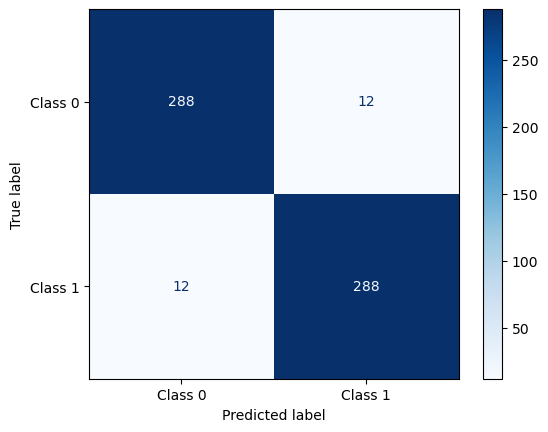

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(df_result['label'], df_result['label_predicted'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues", values_format="d")

In [10]:
# Calculate mean and median similarity scores for label = 1
mean_label_1 = round(df_result[df_result['label'] == 1]['Similarity_score'].mean(), 4)
median_label_1 = round(df_result[df_result['label'] == 1]['Similarity_score'].median(), 4)

# Calculate mean and median similarity scores for label = 0
mean_label_0 = round(df_result[df_result['label'] == 0]['Similarity_score'].mean(), 4)
median_label_0 = round(df_result[df_result['label'] == 0]['Similarity_score'].median(), 4)

# Calculate differences between label 1 and label 0
mean_difference = round(mean_label_1 - mean_label_0, 4)
median_difference = round(median_label_1 - median_label_0, 4)

# Output the results
print(f"Label 1 - Mean Similarity Score: {mean_label_1}, Median Similarity Score: {median_label_1}")
print(f"Label 0 - Mean Similarity Score: {mean_label_0}, Median Similarity Score: {median_label_0}")
print(f"Difference - Mean: {mean_difference}, Median: {median_difference}")

Label 1 - Mean Similarity Score: 0.882099986076355, Median Similarity Score: 0.8906
Label 0 - Mean Similarity Score: 0.7311000227928162, Median Similarity Score: 0.7498
Difference - Mean: 0.1509999930858612, Median: 0.1408


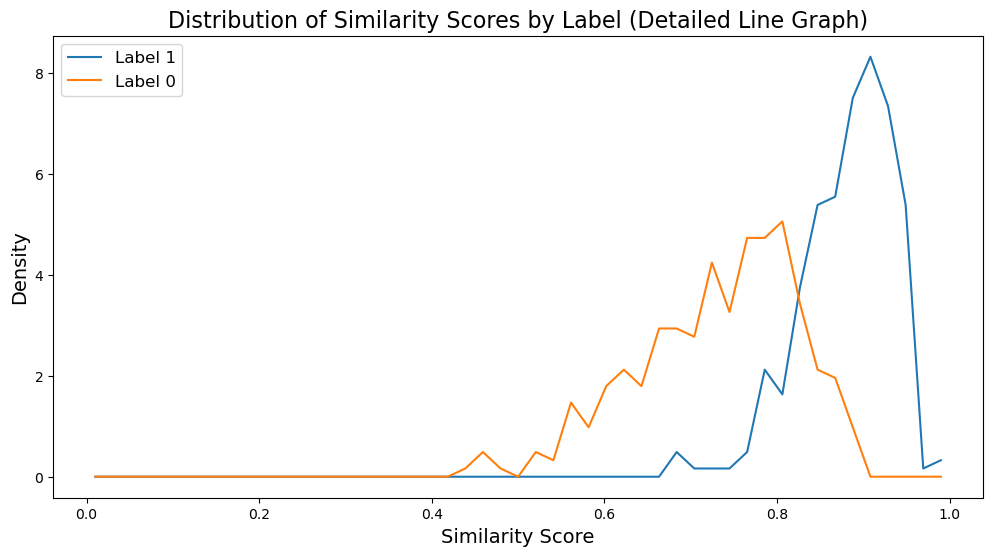

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Separate similarity scores for label = 1 and label = 0
scores_label_1 = df_result[df_result['label'] == 1]['Similarity_score']
scores_label_0 = df_result[df_result['label'] == 0]['Similarity_score']

# Create histogram data for both labels with more bins (50 bins)
bins = np.linspace(0, 1, 50)  # Define bins from 0 to 1 for the similarity scores
hist_label_1, _ = np.histogram(scores_label_1, bins=bins, density=True)
hist_label_0, _ = np.histogram(scores_label_0, bins=bins, density=True)

# Calculate the bin centers for the line plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist_label_1, label='Label 1')
plt.plot(bin_centers, hist_label_0, label='Label 0')

# Add titles and labels
plt.title('Distribution of Similarity Scores by Label (Detailed Line Graph)', fontsize=16)
plt.xlabel('Similarity Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.show()

#### 1.4.1.1 Inspecting the Results

In [12]:
# Filter the rows where "label" and "label_predicted" do not match
df_mismatched = df_result[df_result['label'] != df_result['label_predicted']]

# Display the filtered DataFrame
df_mismatched.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,**Resume**\n\n**John Smith** \n123 Tech Lane ...,0,0.878676,1
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,"**Jessica M. Anderson** \nDenver, CO 80202 \...",1,0.850653,0
111,19,Machine Learning Engineer,a Bit About Us 🧑‍💻 Quinn started as a dream ou...,194,"**Jane Doe** \nSeattle, WA | (555) 123-4567 |...",0,0.859943,1
109,19,Machine Learning Engineer,a Bit About Us 🧑‍💻 Quinn started as a dream ou...,192,"**Alex Thompson** \n[Your Address] \n[City, ...",1,0.781876,0
159,27,Software Engineer,Facebook's mission is to give people the power...,274,"**Jane Smith** \n[Your Address] \n[City, Sta...",0,0.797087,1


In [13]:
# Identify JD_IDs with mismatched rows
mismatched_jd_ids = df_result.loc[df_result['label'] != df_result['label_predicted'], 'JD_ID'].unique()

# Filter the DataFrame to include only rows with these JD_IDs
df_mismatched_jd_ids = df_result[df_result['JD_ID'].isin(mismatched_jd_ids)]

# Display the filtered DataFrame
df_mismatched_jd_ids.head(6)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
8,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,23,"**John Doe** \n[Your Address] \n[City, State...",1,0.935291,1
6,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,"**John D. Smith** \n[Your Address] \n[City, ...",1,0.897163,1
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,**Resume**\n\n**John Smith** \n123 Tech Lane ...,0,0.878676,1
11,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,26,**Resume**\n\n**Johnathan Smith**\n123 Elm Str...,0,0.865572,0
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,"**Jessica M. Anderson** \nDenver, CO 80202 \...",1,0.850653,0
10,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,25,**Resume of Alex Johnson** \n[Alex.Johnson@em...,0,0.815020,0


In [14]:
# Sort the DataFrame by JD_ID and Similarity_score
df_mismatched_jd_ids = df_mismatched_jd_ids.sort_values(by=['JD_ID', 'Similarity_score'], ascending=[True, False])

# Display the sorted DataFrame
df_mismatched_jd_ids.head(6)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
8,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,23,"**John Doe** \n[Your Address] \n[City, State...",1,0.935291,1
6,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,"**John D. Smith** \n[Your Address] \n[City, ...",1,0.897163,1
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,**Resume**\n\n**John Smith** \n123 Tech Lane ...,0,0.878676,1
11,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,26,**Resume**\n\n**Johnathan Smith**\n123 Elm Str...,0,0.865572,0
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,"**Jessica M. Anderson** \nDenver, CO 80202 \...",1,0.850653,0
10,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,25,**Resume of Alex Johnson** \n[Alex.Johnson@em...,0,0.815020,0


### 1.4.2 Second Attempt

**Dataset Specs:**
- 20 JDs a 6 CVs
- "very good fit" vs. "moderate fit"

**Model Specs:**
- Bunch-of-Skills
- all-mpnet-base-v2

In [4]:
import pandas as pd

# Import the CSV file into a dataframe
file_path = "/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_2_test.csv"
df_synth_data_2_test = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify the import
df_synth_data_2_test

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Resume: Sophia Richards** \n[Your Address] ...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**Johnathan C. Miller** \n123 Data Lane, City...",1
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",1
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Alice Johnson** \n123 Innovat...,0
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Johnathan Miller** \n123 Innovation Way \n...,0
...,...,...,...,...,...,...
115,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,"**John D. Anderson** \n[Los Angeles, CA] \n[...",1
116,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,"**Johnathan Reyes** \n1234 Galactic Way, Hawt...",1
117,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,**John Doe** \n123 Stellar Drive \nHawthorne...,0
118,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,205,**John R. Thompson** \n1234 Tech Lane \nHawt...,0


In [21]:
df_result_2_test = main_synth_df(df_synth_data_2_test)

df_result_2_test.head(3)

Processing Time: 44783.08ms


,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Resume: Sophia Richards** \n[Your Address] ...,1,0.929899
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**Johnathan C. Miller** \n123 Data Lane, City...",1,0.895550
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",1,0.881216


In [22]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result_2_test = df_result_2_test.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result_2_test['label_predicted'] = df_result_2_test.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result_2_test

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Johnathan Miller** \n123 Innovation Way \n...,0,0.944611,1
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Alice Johnson** \n123 Innovat...,0,0.937130,1
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Resume: Sophia Richards** \n[Your Address] ...,1,0.929899,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**Johnathan C. Miller** \n123 Data Lane, City...",1,0.895550,0
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",1,0.881216,0
...,...,...,...,...,...,...,...,...
115,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,"**John D. Anderson** \n[Los Angeles, CA] \n[...",1,0.916681,1
119,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,206,"**John D. Carter** \n[Your Address] \n[City,...",0,0.887133,1
116,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,"**Johnathan Reyes** \n1234 Galactic Way, Hawt...",1,0.882098,0
117,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,**John Doe** \n123 Stellar Drive \nHawthorne...,0,0.857641,0


In [23]:
df_result_2_test["label_predicted"].value_counts()

label_predicted
1    60
0    60
Name: count, dtype: int64

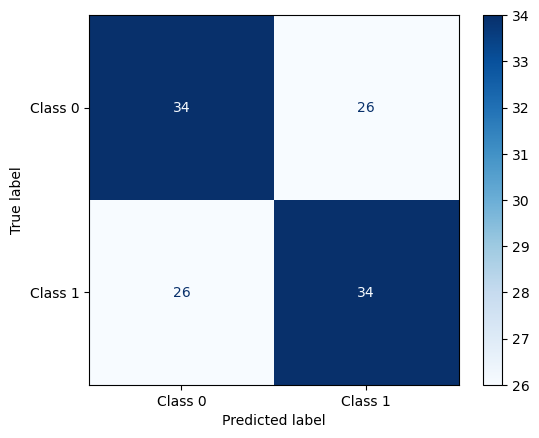

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm_2_test = confusion_matrix(df_result_2_test['label'], df_result_2_test['label_predicted'])

# Display the confusion matrix
disp_2_test = ConfusionMatrixDisplay(confusion_matrix=cm_2_test, display_labels=["Class 0", "Class 1"])
disp_2_test.plot(cmap="Blues", values_format="d")

In [25]:
# Calculate mean and median similarity scores for label = 1
mean_label_1_2_test = round(df_result_2_test[df_result_2_test['label'] == 1]['Similarity_score'].mean(), 4)
median_label_1_2_test = round(df_result_2_test[df_result_2_test['label'] == 1]['Similarity_score'].median(), 4)

# Calculate mean and median similarity scores for label = 0
mean_label_0_2_test = round(df_result_2_test[df_result_2_test['label'] == 0]['Similarity_score'].mean(), 4)
median_label_0_2_test = round(df_result_2_test[df_result_2_test['label'] == 0]['Similarity_score'].median(), 4)

# Calculate differences between label 1 and label 0
mean_difference_2_test = round(mean_label_1_2_test - mean_label_0_2_test, 4)
median_difference_2_test = round(median_label_1_2_test - median_label_0_2_test, 4)

# Output the results
print(f"Label 1 - Mean Similarity Score: {mean_label_1_2_test}, Median Similarity Score: {median_label_1_2_test}")
print(f"Label 0 - Mean Similarity Score: {mean_label_0_2_test}, Median Similarity Score: {median_label_0_2_test}")
print(f"Difference - Mean: {mean_difference_2_test}, Median: {median_difference_2_test}")

Label 1 - Mean Similarity Score: 0.870199978351593, Median Similarity Score: 0.8832
Label 0 - Mean Similarity Score: 0.8567000031471252, Median Similarity Score: 0.8579
Difference - Mean: 0.013500000350177288, Median: 0.0253


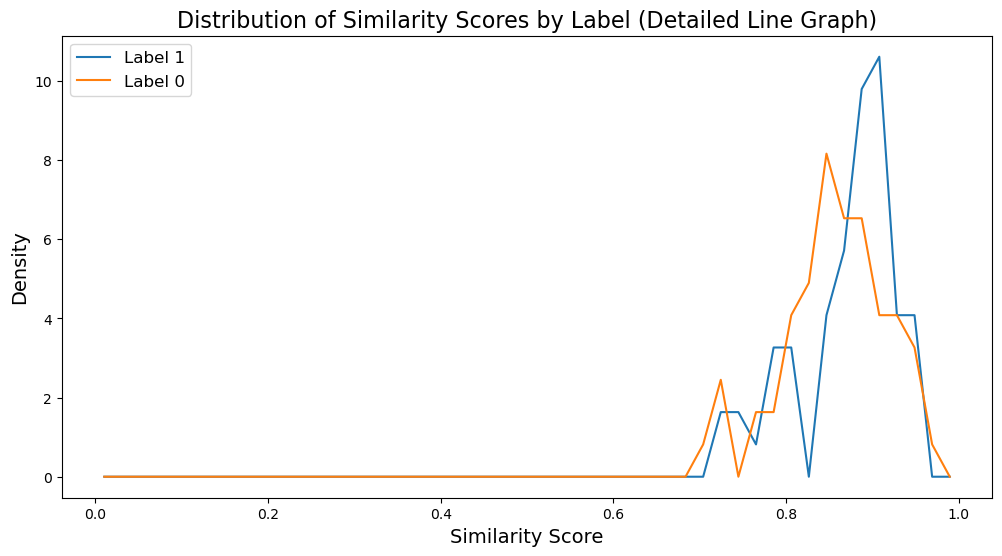

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Separate similarity scores for label = 1 and label = 0
scores_label_1 = df_result_2_test[df_result_2_test['label'] == 1]['Similarity_score']
scores_label_0 = df_result_2_test[df_result_2_test['label'] == 0]['Similarity_score']

# Create histogram data for both labels with more bins (50 bins)
bins = np.linspace(0, 1, 50)  # Define bins from 0 to 1 for the similarity scores
hist_label_1, _ = np.histogram(scores_label_1, bins=bins, density=True)
hist_label_0, _ = np.histogram(scores_label_0, bins=bins, density=True)

# Calculate the bin centers for the line plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist_label_1, label='Label 1')
plt.plot(bin_centers, hist_label_0, label='Label 0')

# Add titles and labels
plt.title('Distribution of Similarity Scores by Label (Detailed Line Graph)', fontsize=16)
plt.xlabel('Similarity Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.show()

### 1.2.3 Third Attempt

**Dataset Specs:**
- 20 JDs a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Bunch-of-skills
- all-mpnet-base-v2

In [3]:
import pandas as pd

# Import the CSV file into a dataframe
file_path = "/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_3_test.csv"
df_synth_data_3_test = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify the import
df_synth_data_3_test

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Data Scientist,If you’re passionate about building a better f...,11,"**Jane Doe** \n123 Tech Lane \nSeattle, WA 9...",1
1,1,Data Scientist,If you’re passionate about building a better f...,12,**John A. Smith** \n123 Data Lane \nTech Cit...,1
2,1,Data Scientist,If you’re passionate about building a better f...,13,**Resume** \n**Johnathan Turner** \n1234 Dat...,1
3,1,Data Scientist,If you’re passionate about building a better f...,14,"**James Carter**\n123 Data St. \nTech City, C...",0
4,1,Data Scientist,If you’re passionate about building a better f...,15,"**Jane D. Mitchell** \nLos Angeles, CA \njan...",0
...,...,...,...,...,...,...
115,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,"**Michael A. Thompson** \nHawthorne, CA 90250...",1
116,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,**John D. Astronaut** \n123 Spaceway Drive \...,1
117,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,**Johnathan D. Miller** \n123 Tech Lane \nSa...,0
118,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,205,"**John D. Mitchell** \nLos Angeles, CA \n(55...",0


In [28]:
df_result_3_test = main_synth_df(df_synth_data_3_test)

df_result_3_test.head(3)

Processing Time: 46574.38ms


,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Data Scientist,If you’re passionate about building a better f...,11,"**Jane Doe** \n123 Tech Lane \nSeattle, WA 9...",1,0.785461
1,1,Data Scientist,If you’re passionate about building a better f...,12,**John A. Smith** \n123 Data Lane \nTech Cit...,1,0.929566
2,1,Data Scientist,If you’re passionate about building a better f...,13,**Resume** \n**Johnathan Turner** \n1234 Dat...,1,0.947198


In [29]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result_3_test = df_result_3_test.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result_3_test['label_predicted'] = df_result_3_test.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result_3_test

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
2,1,Data Scientist,If you’re passionate about building a better f...,13,**Resume** \n**Johnathan Turner** \n1234 Dat...,1,0.947198,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,**John A. Smith** \n123 Data Lane \nTech Cit...,1,0.929566,1
0,1,Data Scientist,If you’re passionate about building a better f...,11,"**Jane Doe** \n123 Tech Lane \nSeattle, WA 9...",1,0.785461,1
4,1,Data Scientist,If you’re passionate about building a better f...,15,"**Jane D. Mitchell** \nLos Angeles, CA \njan...",0,0.781126,0
3,1,Data Scientist,If you’re passionate about building a better f...,14,"**James Carter**\n123 Data St. \nTech City, C...",0,0.742755,0
...,...,...,...,...,...,...,...,...
116,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,**John D. Astronaut** \n123 Spaceway Drive \...,1,0.917859,1
115,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,"**Michael A. Thompson** \nHawthorne, CA 90250...",1,0.907967,1
119,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,206,"**John D. Robinson** \nLos Angeles, CA 90001 ...",0,0.758868,0
117,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,**Johnathan D. Miller** \n123 Tech Lane \nSa...,0,0.693455,0


In [30]:
df_result_3_test["label_predicted"].value_counts()

label_predicted
1    60
0    60
Name: count, dtype: int64

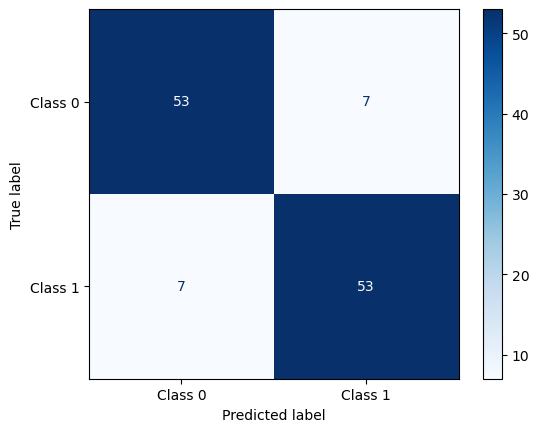

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm_3_test = confusion_matrix(df_result_3_test['label'], df_result_3_test['label_predicted'])

# Display the confusion matrix
disp_3_test = ConfusionMatrixDisplay(confusion_matrix=cm_3_test, display_labels=["Class 0", "Class 1"])
disp_3_test.plot(cmap="Blues", values_format="d")

In [32]:
# Calculate mean and median similarity scores for label = 1
mean_label_1_3_test = round(df_result_3_test[df_result_3_test['label'] == 1]['Similarity_score'].mean(), 4)
median_label_1_3_test = round(df_result_3_test[df_result_3_test['label'] == 1]['Similarity_score'].median(), 4)

# Calculate mean and median similarity scores for label = 0
mean_label_0_3_test = round(df_result_3_test[df_result_3_test['label'] == 0]['Similarity_score'].mean(), 4)
median_label_0_3_test = round(df_result_3_test[df_result_3_test['label'] == 0]['Similarity_score'].median(), 4)

# Calculate differences between label 1 and label 0
mean_difference_3_test = round(mean_label_1_3_test - mean_label_0_3_test, 4)
median_difference_3_test = round(median_label_1_3_test - median_label_0_3_test, 4)

# Output the results
print(f"Label 1 - Mean Similarity Score: {mean_label_1_3_test}, Median Similarity Score: {median_label_1_3_test}")
print(f"Label 0 - Mean Similarity Score: {mean_label_0_3_test}, Median Similarity Score: {median_label_0_3_test}")
print(f"Difference - Mean: {mean_difference_3_test}, Median: {median_difference_3_test}")

Label 1 - Mean Similarity Score: 0.8690000176429749, Median Similarity Score: 0.8843
Label 0 - Mean Similarity Score: 0.7692000269889832, Median Similarity Score: 0.7855
Difference - Mean: 0.0997999981045723, Median: 0.0988


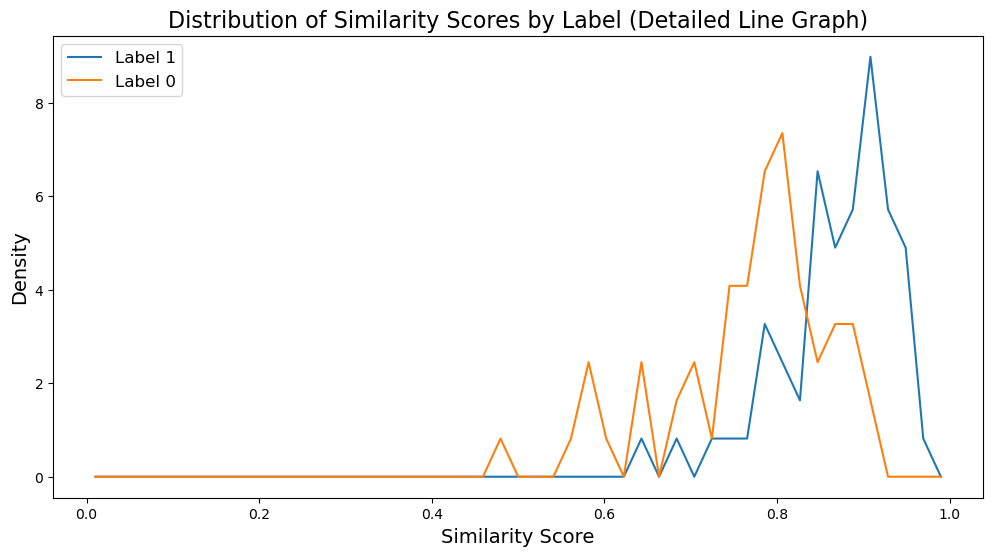

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Separate similarity scores for label = 1 and label = 0
scores_label_1 = df_result_3_test[df_result_3_test['label'] == 1]['Similarity_score']
scores_label_0 = df_result_3_test[df_result_3_test['label'] == 0]['Similarity_score']

# Create histogram data for both labels with more bins (50 bins)
bins = np.linspace(0, 1, 50)  # Define bins from 0 to 1 for the similarity scores
hist_label_1, _ = np.histogram(scores_label_1, bins=bins, density=True)
hist_label_0, _ = np.histogram(scores_label_0, bins=bins, density=True)

# Calculate the bin centers for the line plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist_label_1, label='Label 1')
plt.plot(bin_centers, hist_label_0, label='Label 0')

# Add titles and labels
plt.title('Distribution of Similarity Scores by Label (Detailed Line Graph)', fontsize=16)
plt.xlabel('Similarity Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.show()

### 1.4.4 Fourth Attempt (Same as 1.4.3 but with 100 JDs)

**Dataset Specs:**
- **100 JDs** a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Bunch-of-skills
- all-mpnet-base-v2

In [3]:
import pandas as pd

# Import the CSV file into a dataframe
file_path = "/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_4_100.csv"
df_synth_data_4_100 = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify the import
df_synth_data_4_100

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**John D. Smith** \n123 Cloud Lane \nPleasan...,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**Resume**\n\n**John Doe** \n[Your Address] ...,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n[Email: john.smith@email.com...,0
...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Doe** \n123 Tech Lane \nAustin, TX 78...",1
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,"**John Doe** \n1234 Tech Lane \nAustin, TX 7...",1
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n123 Tech Lane, Silicon Valley,...",0
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,**John Doe** \n123 Tech Lane \nSan Francisco...,0


In [72]:
df_result_4_100_bos_allmpnet = main_synth_df(df_synth_data_4_100)

df_result_4_100_bos_allmpnet.head(3)

Processing Time: 324050.03ms


,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**John D. Smith** \n123 Cloud Lane \nPleasan...,1,0.919472
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",1,0.879331
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**Resume**\n\n**John Doe** \n[Your Address] ...,1,0.909718


In [73]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result_4_100_bos_allmpnet = df_result_4_100_bos_allmpnet.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result_4_100_bos_allmpnet['label_predicted'] = df_result_4_100_bos_allmpnet.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result_4_100_bos_allmpnet

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**John D. Smith** \n123 Cloud Lane \nPleasan...,1,0.919472,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**Resume**\n\n**John Doe** \n[Your Address] ...,1,0.909718,1
5,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,**John W. Smith** \n123 Tech Avenue \nSan Fr...,0,0.889966,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",1,0.879331,0
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,0,0.833586,0
...,...,...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Doe** \n123 Tech Lane \nAustin, TX 78...",1,0.938215,1
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,"**John Doe** \n1234 Tech Lane \nAustin, TX 7...",1,0.890457,1
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,**John Doe** \n123 Tech Lane \nSan Francisco...,0,0.847743,0
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n123 Tech Lane, Silicon Valley,...",0,0.838664,0


In [74]:
df_result_4_100_bos_allmpnet["label_predicted"].value_counts()

label_predicted
1    300
0    300
Name: count, dtype: int64

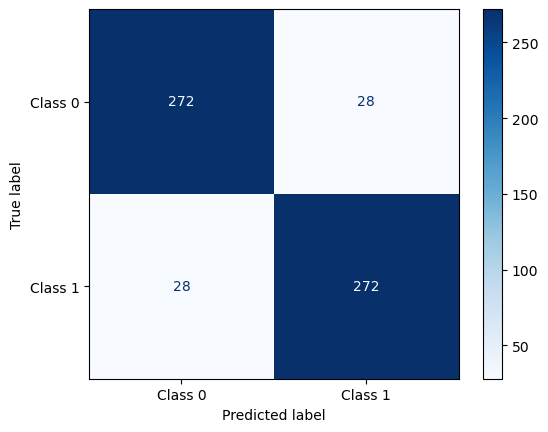

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm_4_100 = confusion_matrix(df_result_4_100_bos_allmpnet['label'], df_result_4_100_bos_allmpnet['label_predicted'])

# Display the confusion matrix
disp_4_100 = ConfusionMatrixDisplay(confusion_matrix=cm_4_100, display_labels=["Class 0", "Class 1"])
disp_4_100.plot(cmap="Blues", values_format="d")

In [76]:
# Calculate mean and median similarity scores for label = 1
mean_label_1_4_100 = round(df_result_4_100_bos_allmpnet[df_result_4_100_bos_allmpnet['label'] == 1]['Similarity_score'].mean(), 4)
median_label_1_4_100 = round(df_result_4_100_bos_allmpnet[df_result_4_100_bos_allmpnet['label'] == 1]['Similarity_score'].median(), 4)

# Calculate mean and median similarity scores for label = 0
mean_label_0_4_100 = round(df_result_4_100_bos_allmpnet[df_result_4_100_bos_allmpnet['label'] == 0]['Similarity_score'].mean(), 4)
median_label_0_4_100 = round(df_result_4_100_bos_allmpnet[df_result_4_100_bos_allmpnet['label'] == 0]['Similarity_score'].median(), 4)

# Calculate differences between label 1 and label 0
mean_difference_4_100 = round(mean_label_1_4_100 - mean_label_0_4_100, 4)
median_difference_4_100 = round(median_label_1_4_100 - median_label_0_4_100, 4)

# Output the results
print(f"Label 1 - Mean Similarity Score: {mean_label_1_4_100}, Median Similarity Score: {median_label_1_4_100}")
print(f"Label 0 - Mean Similarity Score: {mean_label_0_4_100}, Median Similarity Score: {median_label_0_4_100}")
print(f"Difference - Mean: {mean_difference_4_100}, Median: {median_difference_4_100}")

Label 1 - Mean Similarity Score: 0.8784000277519226, Median Similarity Score: 0.8875
Label 0 - Mean Similarity Score: 0.7548999786376953, Median Similarity Score: 0.7643
Difference - Mean: 0.12349999696016312, Median: 0.1232


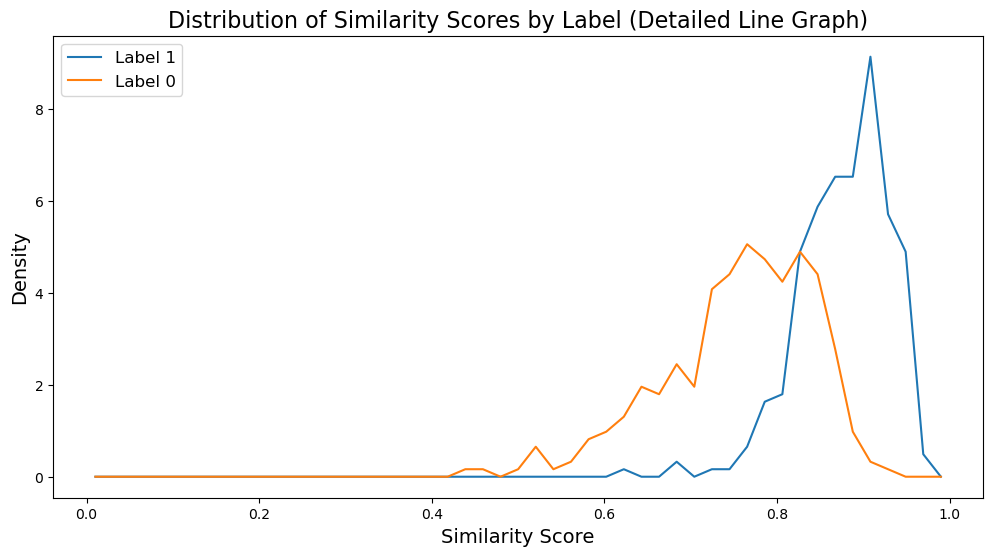

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Separate similarity scores for label = 1 and label = 0
scores_label_1 = df_result_4_100_bos_allmpnet[df_result_4_100_bos_allmpnet['label'] == 1]['Similarity_score']
scores_label_0 = df_result_4_100_bos_allmpnet[df_result_4_100_bos_allmpnet['label'] == 0]['Similarity_score']

# Create histogram data for both labels with more bins (50 bins)
bins = np.linspace(0, 1, 50)  # Define bins from 0 to 1 for the similarity scores
hist_label_1, _ = np.histogram(scores_label_1, bins=bins, density=True)
hist_label_0, _ = np.histogram(scores_label_0, bins=bins, density=True)

# Calculate the bin centers for the line plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist_label_1, label='Label 1')
plt.plot(bin_centers, hist_label_0, label='Label 0')

# Add titles and labels
plt.title('Distribution of Similarity Scores by Label (Detailed Line Graph)', fontsize=16)
plt.xlabel('Similarity Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.show()

### 1.4.5 Fifth Attempt (Ranking)

**Dataset Specs:**
- **20 JDs** a 5 CVs
- Ranked 1-5
- Fit: "perfect", "good", "moderate", "bad", "no"

**Model Specs:**
- Bunch-of-skills
- all-mpnet-base-v2

In [7]:
import pandas as pd

# Import the CSV file into a dataframe
file_path = "/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data_5_20.csv"
df_synth_data_5_20 = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify the import
df_synth_data_5_20

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Michael J. Thompson** \n[Your Address] \n[...,1
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**John Smith** \n[Your Address] \n[City, Sta...",2
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**Resume**\n\n**John Doe** \n[City, State] \...",3
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Jessica Taylor** \nEmail: jes...,4
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Resume**\n\n**Name:** Jordan Bennett \n**Ad...,5
...,...,...,...,...,...,...
95,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,201,"**Samuel Harper** \nLos Angeles, CA | samue...",1
96,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,**John M. Carter** \n123 Stellar Way \nHawth...,2
97,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,**Resume**\n\n**John H. Adams** \nSanta Monic...,3
98,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,"**Alexandra Turner** \n123 Maple St, San Dieg...",4


In [102]:
df_result_5_20_bos_allmpnet = main_synth_df(df_synth_data_5_20)

df_result_5_20_bos_allmpnet.head(3)

Processing Time: 46458.88ms


,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Michael J. Thompson** \n[Your Address] \n[...,1,0.880886
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**John Smith** \n[Your Address] \n[City, Sta...",2,0.927024
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**Resume**\n\n**John Doe** \n[City, State] \...",3,0.868997


In [103]:
# Sort the DataFrame by JD_ID and Similarity_score in descending order
df_result_5_20_bos_allmpnet = df_result_5_20_bos_allmpnet.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the ranking logic within each JD_ID group
df_result_5_20_bos_allmpnet['label_predicted'] = df_result_5_20_bos_allmpnet.groupby('JD_ID')['Similarity_score'].rank(ascending=False).astype(int)

# Display the updated DataFrame
df_result_5_20_bos_allmpnet

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**John Smith** \n[Your Address] \n[City, Sta...",2,0.927024,1
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Michael J. Thompson** \n[Your Address] \n[...,1,0.880886,2
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**Resume**\n\n**John Doe** \n[City, State] \...",3,0.868997,3
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Resume**\n\n**Name:** Jordan Bennett \n**Ad...,5,0.614849,4
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Jessica Taylor** \nEmail: jes...,4,0.313561,5
...,...,...,...,...,...,...,...,...
95,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,201,"**Samuel Harper** \nLos Angeles, CA | samue...",1,0.932357,1
96,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,**John M. Carter** \n123 Stellar Way \nHawth...,2,0.903987,2
97,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,203,**Resume**\n\n**John H. Adams** \nSanta Monic...,3,0.896042,3
98,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,"**Alexandra Turner** \n123 Maple St, San Dieg...",4,0.610059,4


In [104]:
df_result_5_20_bos_allmpnet["label_predicted"].value_counts()

label_predicted
1    20
2    20
3    20
4    20
5    20
Name: count, dtype: int64

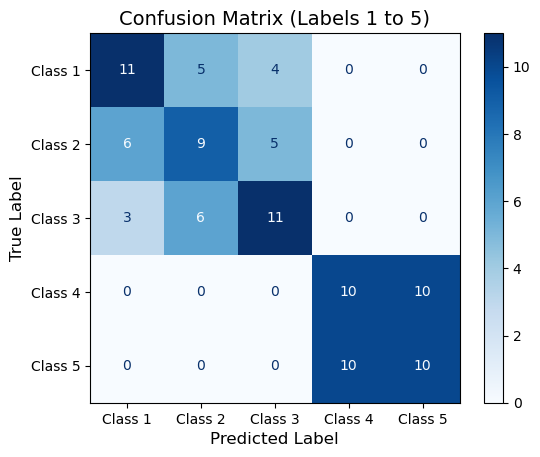

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm_5_20 = confusion_matrix(df_result_5_20_bos_allmpnet['label'], df_result_5_20_bos_allmpnet['label_predicted'])

# Display the confusion matrix
disp_5_20 = ConfusionMatrixDisplay(confusion_matrix=cm_5_20, display_labels=["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
disp_5_20.plot(cmap="Blues", values_format="d")

# Add titles and labels for clarity
disp_5_20.ax_.set_title("Confusion Matrix (Labels 1 to 5)", fontsize=14)
disp_5_20.ax_.set_xlabel("Predicted Label", fontsize=12)
disp_5_20.ax_.set_ylabel("True Label", fontsize=12)

plt.show()

In [106]:
# Initialize dictionaries to store mean and median similarity scores for each label
mean_scores = {}
median_scores = {}

# Loop through each label (1 to 5) to calculate mean and median similarity scores
for label in range(1, 6):
    mean_scores[label] = round(df_result_5_20_bos_allmpnet[df_result_5_20_bos_allmpnet['label'] == label]['Similarity_score'].mean(), 4)
    median_scores[label] = round(df_result_5_20_bos_allmpnet[df_result_5_20_bos_allmpnet['label'] == label]['Similarity_score'].median(), 4)

# Output the results for each label
for label in range(1, 6):
    print(f"Label {label} - Mean Similarity Score: {mean_scores[label]}, Median Similarity Score: {median_scores[label]}")

# Calculate differences between labels (optional, for consecutive labels)
for label in range(1, 5):  # Differences between 1-2, 2-3, etc.
    mean_difference = round(mean_scores[label] - mean_scores[label + 1], 4)
    median_difference = round(median_scores[label] - median_scores[label + 1], 4)
    print(f"Difference between Label {label} and Label {label + 1} - Mean: {mean_difference}, Median: {median_difference}")

Label 1 - Mean Similarity Score: 0.8761000037193298, Median Similarity Score: 0.8891
Label 2 - Mean Similarity Score: 0.868399977684021, Median Similarity Score: 0.8706
Label 3 - Mean Similarity Score: 0.8496000170707703, Median Similarity Score: 0.8563
Label 4 - Mean Similarity Score: 0.4652999937534332, Median Similarity Score: 0.473
Label 5 - Mean Similarity Score: 0.4733999967575073, Median Similarity Score: 0.4851
Difference between Label 1 and Label 2 - Mean: 0.007699999958276749, Median: 0.0185
Difference between Label 2 and Label 3 - Mean: 0.018799999728798866, Median: 0.0143
Difference between Label 3 and Label 4 - Mean: 0.38429999351501465, Median: 0.3833
Difference between Label 4 and Label 5 - Mean: -0.008100000210106373, Median: -0.0121


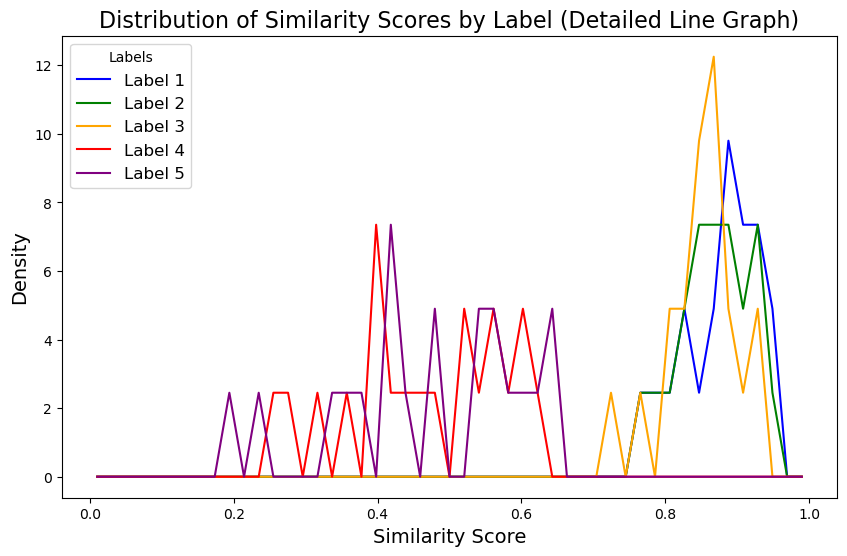

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Create a color map for labels
colors = ['blue', 'green', 'orange', 'red', 'purple']

# Define bins for the histogram
bins = np.linspace(0, 1, 50)  # Define bins from 0 to 1 for the similarity scores
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for the line plot

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the distribution for each label (1 to 5)
for label, color in zip(range(1, 6), colors):
    scores = df_result_5_20_bos_allmpnet[df_result_5_20_bos_allmpnet['label'] == label]['Similarity_score']
    hist, _ = np.histogram(scores, bins=bins, density=True)
    plt.plot(bin_centers, hist, label=f'Label {label}', color=color)

# Add titles and labels
plt.title('Distribution of Similarity Scores by Label (Detailed Line Graph)', fontsize=16)
plt.xlabel('Similarity Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12, title="Labels")

# Display the plot
plt.show()

# 2 Improving the Model Components

## Model Pipeline
1. **Skills Extraction:** Skills Dictionary (baseline) vs. Taxonomy
2. **Input for Embeddings:** Bunch-of-skills (baseline) vs. Skill-by-skill
3. **Embedding Models:** all-mpnet-base-v2 (baseline) vs. Huggingface leaderboard Models
4. **Modelling Approach:** Bi-Encoder (baseline) vs. Cross-Encoder

## Function for Performance Analysis:

In [8]:
# Performance Analysis Function for 1 df
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
)

def performance_analysis(df):
    # Dynamically get the name of the DataFrame passed to the function
    df_name = [key for key, value in globals().items() if value is df][0]

    # 1. Count "label" and "label_predicted" values
    print(f"\n{df_name} - Label Counts:")
    print(df["label"].value_counts())
    print(f"\n{df_name} - Label Predicted Counts:")
    print(df["label_predicted"].value_counts())

    # 2. Mean and median similarity scores
    mean_label_1 = round(df[df['label'] == 1]['Similarity_score'].mean(), 4)
    median_label_1 = round(df[df['label'] == 1]['Similarity_score'].median(), 4)
    mean_label_0 = round(df[df['label'] == 0]['Similarity_score'].mean(), 4)
    median_label_0 = round(df[df['label'] == 0]['Similarity_score'].median(), 4)
    mean_difference = round(mean_label_1 - mean_label_0, 4)
    median_difference = round(median_label_1 - median_label_0, 4)

    print(f"\n{df_name} - Similarity Scores:")
    print(f"Label 1 - Mean: {mean_label_1}, Median: {median_label_1}")
    print(f"Label 0 - Mean: {mean_label_0}, Median: {median_label_0}")
    print(f"Difference - Mean: {mean_difference}, Median: {median_difference}")

    # 3. Distribution plot for similarity scores
    scores_label_1 = df[df['label'] == 1]['Similarity_score']
    scores_label_0 = df[df['label'] == 0]['Similarity_score']

    bins = np.linspace(0, 1, 50)
    hist_label_1, _ = np.histogram(scores_label_1, bins=bins, density=True)
    hist_label_0, _ = np.histogram(scores_label_0, bins=bins, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.figure(figsize=(8, 4))
    plt.plot(bin_centers, hist_label_1, label="Label 1")
    plt.plot(bin_centers, hist_label_0, label="Label 0")
    plt.title(f'Distribution of Similarity Scores by Label ({df_name})', fontsize=16)
    plt.xlabel('Similarity Score', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

    # 4. Confusion matrix
    cm = confusion_matrix(df['label'], df['label_predicted'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix ({df_name})", fontsize=16)
    plt.show()

    # 5. Accuracy, Precision, Recall, and F1-Score
    accuracy = accuracy_score(df['label'], df['label_predicted'])
    precision = precision_score(df['label'], df['label_predicted'])
    recall = recall_score(df['label'], df['label_predicted'])
    f1 = f1_score(df['label'], df['label_predicted'])

    metrics_df = pd.DataFrame(
        {
            df_name: [accuracy, precision, recall, f1],
        },
        index=["Accuracy", "Precision", "Recall", "F1-Score"]
    )
    print("\nPerformance Metrics:")
    print(metrics_df)

    # 6. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(df['label'], df['Similarity_score'])
    plt.figure(figsize=(8, 4))
    plt.plot(recall, precision, label=df_name)
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.xlabel("Recall", fontsize=14)
    plt.ylabel("Precision", fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

## 2.1 Skills Extraction: Skills Dictionary (baseline) vs. Taxonomy

## 2.2 Input for Embeddings: Bunch-of-skills (baseline) vs. Skill-by-skill

### 2.2.1 Bunch-of-skills (Baseline Model)

**Dataset Specs:**
- 100 JDs a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Bunch-of-skills
- all-mpnet-base-v2


df_result_4_100_bos_allmpnet - Label Predicted Counts:
label_predicted
1    300
0    300
Name: count, dtype: int64

df_result_4_100_bos_allmpnet - Similarity Scores:
Label 1 - Mean: 0.8784000277519226, Median: 0.8875
Label 0 - Mean: 0.7548999786376953, Median: 0.7643
Difference - Mean: 0.12349999696016312, Median: 0.1232


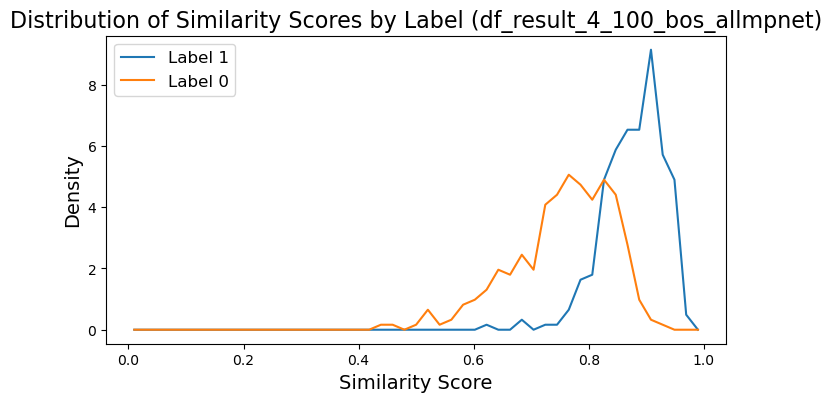

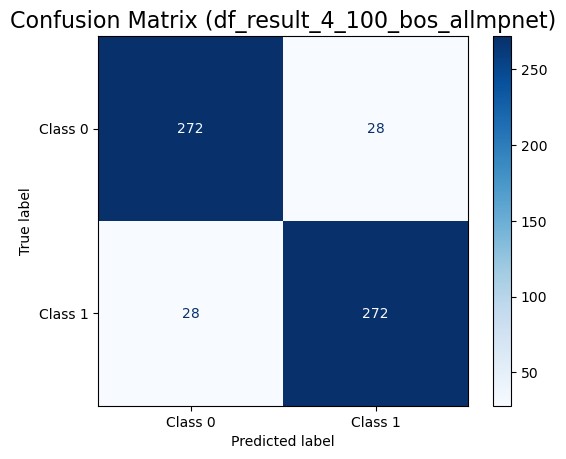


Performance Metrics:
           df_result_4_100_bos_allmpnet
Accuracy                       0.906667
Precision                      0.906667
Recall                         0.906667
F1-Score                       0.906667


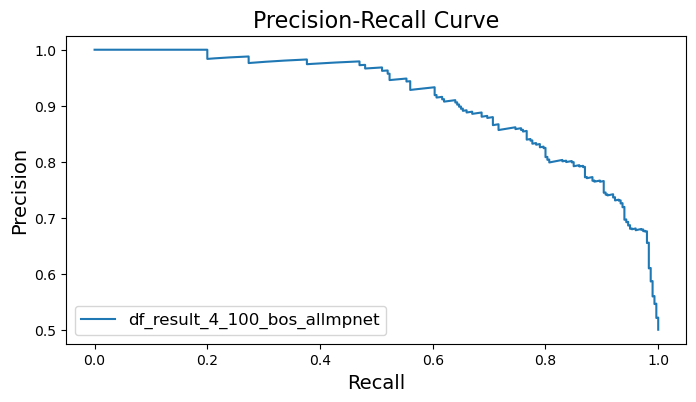

In [78]:
performance_analysis(df_result_4_100_bos_allmpnet)

### 2.2.2 Skill-by-skill

#### 2.2.2.1 Using df_synth_data_4_100

**Dataset Specs:**
- **100 JDs** a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Skill-by-skill
- all-mpnet-base-v2

In [79]:
def main_synth_sbs_df(synth_data):
    t0 = time.time()

    # Initialize an empty list to store results
    similarity_results = []

    # Iterate over each unique job description ID in the dataset
    for jd_id in synth_data['JD_ID'].unique():
        # Filter the data for the current job description
        job_data = synth_data[synth_data['JD_ID'] == jd_id]

        # Extract the job description text
        jd_text = job_data.iloc[0]['JD_text']
        df_jobs = pd.DataFrame([jd_text], columns=["raw"])
        df_jobs = job_info_extraction(df_jobs)  # Extract job description skills
        df_jobs = df_jobs.reset_index(drop=True)  # Ensure consistent indexing
        
        # Extract resumes for this job description
        resumes = job_data[['CV_ID', 'CV_text']].copy()
        resumes['name'] = resumes['CV_ID']
        resumes['raw'] = resumes['CV_text']
        df_resumes = resume_extraction(resumes)
        df_resumes = df_resumes.reset_index(drop=True)  # Ensure consistent indexing

        # Ensure the Skills column exists
        if 'Skills' not in df_jobs.columns or 'Skills' not in df_resumes.columns:
            raise ValueError("The 'Skills' column is missing in one of the extracted DataFrames.")
        
        # Calculate similarity for the job description and its related resumes
        analysis_data_df = calc_similarity_sbs(df_resumes, df_jobs)
        
        # Add similarity scores back to the original data
        job_data = job_data.reset_index(drop=True)
        job_data['Similarity_score'] = analysis_data_df['all-mpnet-base-v2_score']

        # Append to results
        similarity_results.append(job_data)

    # Combine all results into a single DataFrame
    df_final = pd.concat(similarity_results, ignore_index=True)

    t1 = time.time()
    dt = t1 - t0
    print(f"Processing Time: {dt*1000:.2f}ms")
    
    return df_final

In [80]:
df_result_4_100_sbs_allmpnet = main_synth_sbs_df(df_synth_data_4_100)

df_result_4_100_sbs_allmpnet.head(3)

Processing Time: 1194515.95ms


,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**John D. Smith** \n123 Cloud Lane \nPleasan...,1,0.811
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",1,0.833
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**Resume**\n\n**John Doe** \n[Your Address] ...,1,0.788


In [ ]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result_4_100_sbs_allmpnet = df_result_4_100_sbs_allmpnet.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result_4_100_sbs_allmpnet['label_predicted'] = df_result_4_100_sbs_allmpnet.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result_4_100_sbs_allmpnet


df_result_4_100_sbs_allmpnet - Label Predicted Counts:
label_predicted
1    300
0    300
Name: count, dtype: int64

df_result_4_100_sbs_allmpnet - Similarity Scores:
Label 1 - Mean: 0.8342, Median: 0.833
Label 0 - Mean: 0.576, Median: 0.5815
Difference - Mean: 0.2582, Median: 0.2515


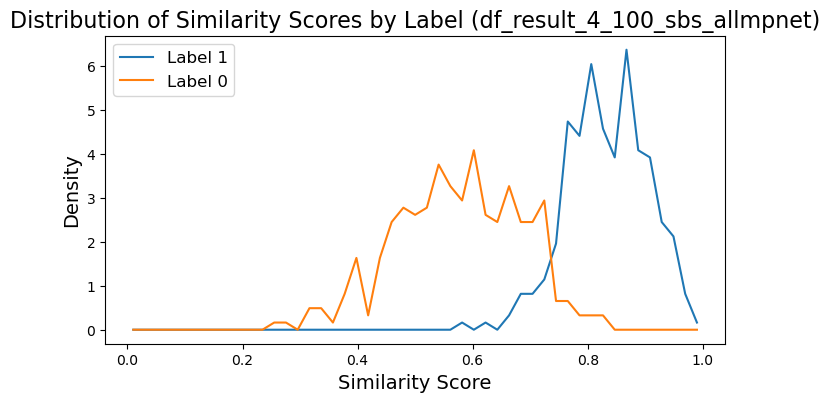

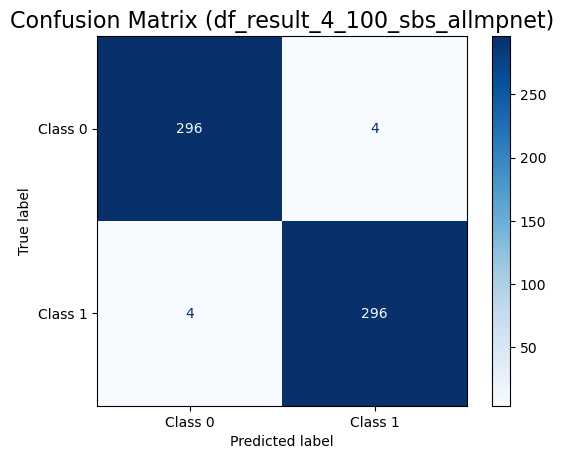


Performance Metrics:
           df_result_4_100_sbs_allmpnet
Accuracy                       0.986667
Precision                      0.986667
Recall                         0.986667
F1-Score                       0.986667


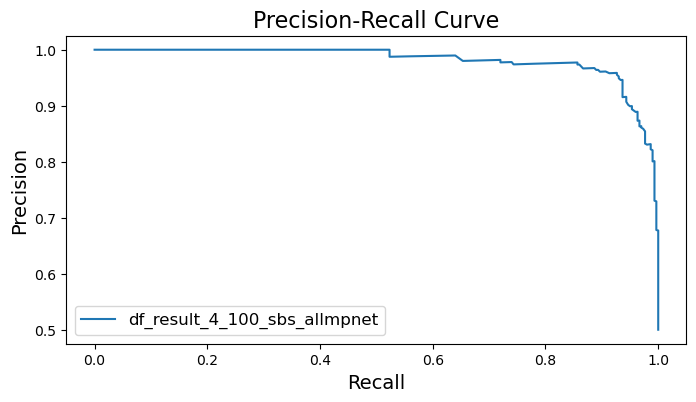

In [82]:
performance_analysis(df_result_4_100_sbs_allmpnet)

#### 2.2.2.2 Using df_synth_data_2_test (20 JDs)

**Dataset Specs:**
- 20 JDs a 6 CVs
- "very good fit" vs. "moderate fit"

**Model Specs:**
- Skill-by-skill
- all-mpnet-base-v2

In [83]:
df_result_2_test_sbs_allmpnet = main_synth_sbs_df(df_synth_data_2_test)

df_result_2_test_sbs_allmpnet.head(3)

Processing Time: 229939.82ms


,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Resume: Sophia Richards** \n[Your Address] ...,1,0.839
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**Johnathan C. Miller** \n123 Data Lane, City...",1,0.885
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",1,0.792


In [84]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result_2_test_sbs_allmpnet = df_result_2_test_sbs_allmpnet.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result_2_test_sbs_allmpnet['label_predicted'] = df_result_2_test_sbs_allmpnet.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result_2_test_sbs_allmpnet

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
1,1,Data Scientist,If you’re passionate about building a better f...,12,"**Johnathan C. Miller** \n123 Data Lane, City...",1,0.885,1
0,1,Data Scientist,If you’re passionate about building a better f...,11,**Resume: Sophia Richards** \n[Your Address] ...,1,0.839,1
4,1,Data Scientist,If you’re passionate about building a better f...,15,**Johnathan Miller** \n123 Innovation Way \n...,0,0.803,1
3,1,Data Scientist,If you’re passionate about building a better f...,14,**Resume**\n\n**Alice Johnson** \n123 Innovat...,0,0.794,0
2,1,Data Scientist,If you’re passionate about building a better f...,13,"**John Doe** \n123 Tech Lane, Apt 4B \nSeatt...",1,0.792,0
...,...,...,...,...,...,...,...,...
114,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,201,"**John Smith** \nLos Angeles, CA | john.smi...",1,0.844,1
115,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,202,"**John D. Anderson** \n[Los Angeles, CA] \n[...",1,0.787,1
119,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,206,"**John D. Carter** \n[Your Address] \n[City,...",0,0.764,0
117,20,Site Reliability Engineer (Spacecraft Engineer...,SpaceX was founded under the belief that a fut...,204,**John Doe** \n123 Stellar Drive \nHawthorne...,0,0.741,0



df_result_2_test_sbs_allmpnet - Label Predicted Counts:
label_predicted
0    61
1    59
Name: count, dtype: int64

df_result_2_test_sbs_allmpnet - Similarity Scores:
Label 1 - Mean: 0.8089, Median: 0.8055
Label 0 - Mean: 0.7447, Median: 0.7385
Difference - Mean: 0.0642, Median: 0.067


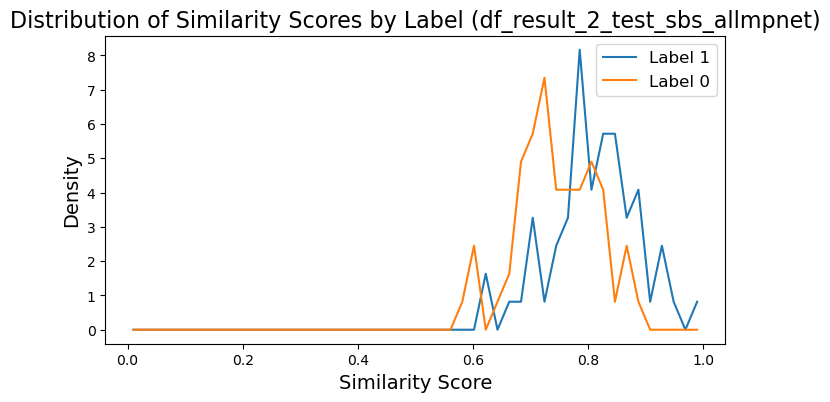

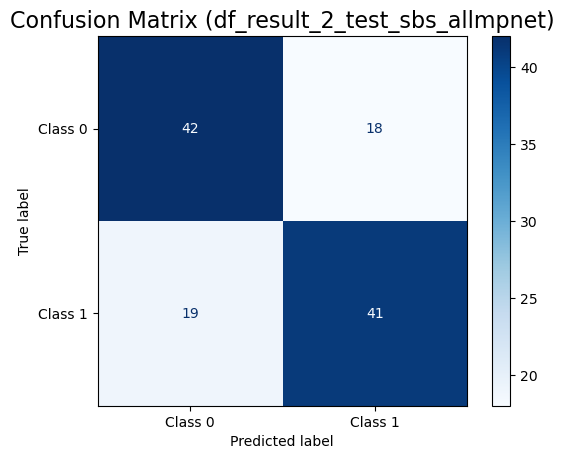


Performance Metrics:
           df_result_2_test_sbs_allmpnet
Accuracy                        0.691667
Precision                       0.694915
Recall                          0.683333
F1-Score                        0.689076


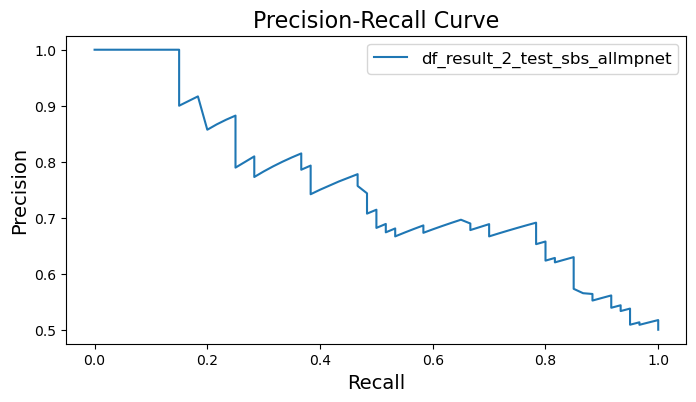

In [85]:
performance_analysis(df_result_2_test_sbs_allmpnet)

<div style="background-color: #fff4e5; border-left: 6px solid #ff4500; padding: 10px; font-size: 16px;">
    The Skill-by-skill approach showed better performance on two different synthetic datasets. Therefore, we will proceed with the skill-by-skill approach for further model component testing.
</div>

## 2.3 Embedding Models: all-mpnet-base-v2 vs. Huggingface leaderboard Models

### 2.3.1 all-mpnet-base-v2 

**Dataset Specs:**
- 100 JDs a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Skill-by-skill
- all-mpnet-base-v2

**"all-mpnet-base-v2" Model Characteristics:**
- Model size: 
- Embedding dimensions: 
- Tokenizer:
- Memory Usage (GB, fp32): 
- Max Tokens: 


df_result_4_100_sbs_allmpnet - Label Predicted Counts:
label_predicted
1    300
0    300
Name: count, dtype: int64

df_result_4_100_sbs_allmpnet - Similarity Scores:
Label 1 - Mean: 0.8342, Median: 0.833
Label 0 - Mean: 0.576, Median: 0.5815
Difference - Mean: 0.2582, Median: 0.2515


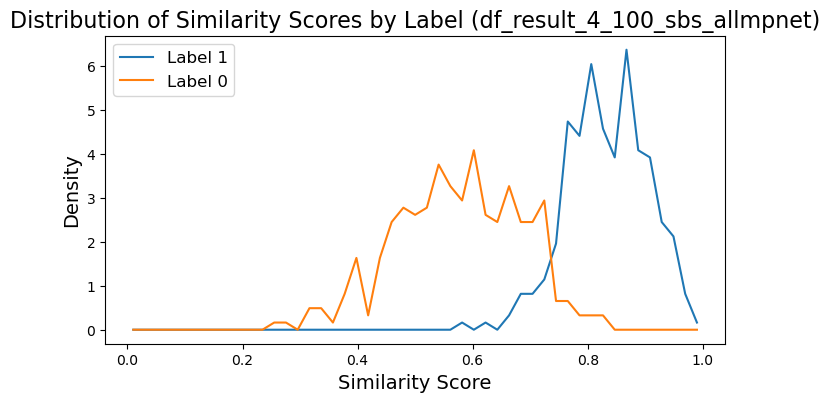

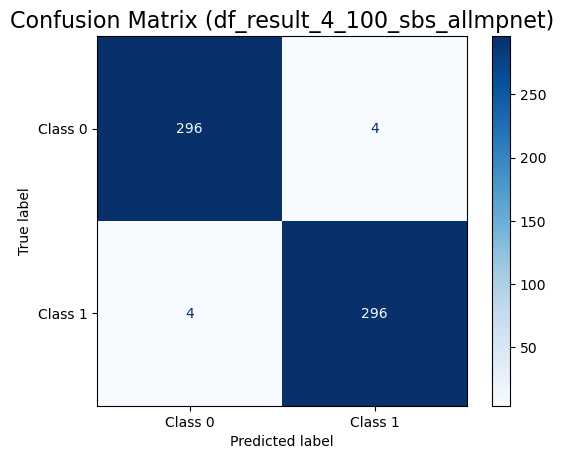


Performance Metrics:
           df_result_4_100_sbs_allmpnet
Accuracy                       0.986667
Precision                      0.986667
Recall                         0.986667
F1-Score                       0.986667


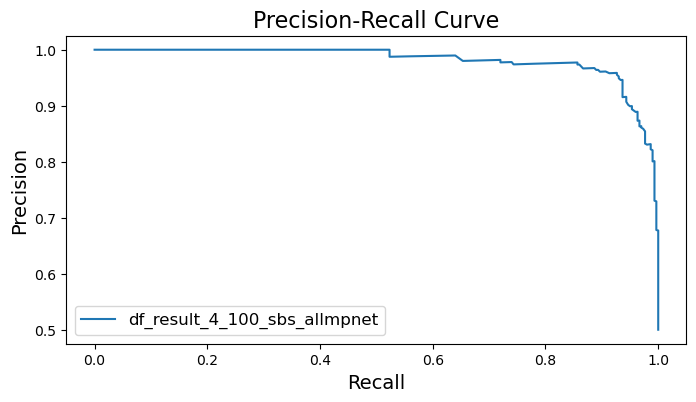

In [86]:
performance_analysis(df_result_4_100_sbs_allmpnet)

### 2.3.2 all-MiniLM-L6-v2

**Dataset Specs:**
- 100 JDs a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Skill-by-skill
- all-MiniLM-L6-v2

**"all-MiniLM-L6-v2" Model Characteristics:**
- Model size: 
- Embedding dimensions: 
- Tokenizer:
- Memory Usage (GB, fp32): 
- Max Tokens: 

#### 2.3.2.1 Function for running the Model

In [11]:
import time

def main_synth_sbs_all_MiniLM_L6_v2_df(synth_data):
    t0 = time.time()

    # Initialize an empty list to store results
    similarity_results = []

    # Iterate over each unique job description ID in the dataset
    for jd_id in synth_data['JD_ID'].unique():
        # Filter the data for the current job description
        job_data = synth_data[synth_data['JD_ID'] == jd_id]

        # Extract the job description text
        jd_text = job_data.iloc[0]['JD_text']
        df_jobs = pd.DataFrame([jd_text], columns=["raw"])
        df_jobs = job_info_extraction(df_jobs)  # Extract job description skills
        df_jobs = df_jobs.reset_index(drop=True)  # Ensure consistent indexing
        
        # Extract resumes for this job description
        resumes = job_data[['CV_ID', 'CV_text']].copy()
        resumes['name'] = resumes['CV_ID']
        resumes['raw'] = resumes['CV_text']
        df_resumes = resume_extraction(resumes)
        df_resumes = df_resumes.reset_index(drop=True)  # Ensure consistent indexing

        # Ensure the Skills column exists
        if 'Skills' not in df_jobs.columns or 'Skills' not in df_resumes.columns:
            raise ValueError("The 'Skills' column is missing in one of the extracted DataFrames.")
        
        # Calculate similarity for the job description and its related resumes
        analysis_data_df = calc_similarity_sbs_all_MiniLM_L6_v2(df_resumes, df_jobs)
        
        # Add similarity scores back to the original data
        job_data = job_data.reset_index(drop=True)
        job_data['Similarity_score'] = analysis_data_df['all-MiniLM-L6-v2_score']

        # Append to results
        similarity_results.append(job_data)

    # Combine all results into a single DataFrame
    df_final = pd.concat(similarity_results, ignore_index=True)

    t1 = time.time()
    dt = t1 - t0
    print(f"Processing Time: {dt*1000:.2f}ms")
    
    return df_final

#### 2.3.2.2 Running the Model

In [ ]:
df_result_4_100_sbs_allMiniLM = main_synth_sbs_all_MiniLM_L6_v2_df(df_synth_data_4_100)

df_result_4_100_sbs_allMiniLM.head(3)

In [96]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result_4_100_sbs_allMiniLM = df_result_4_100_sbs_allMiniLM.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result_4_100_sbs_allMiniLM['label_predicted'] = df_result_4_100_sbs_allMiniLM.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result_4_100_sbs_allMiniLM

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,"**John Doe** \n1234 Tech Lane \nPleasanton, ...",1,0.824,1
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,**John D. Smith** \n123 Cloud Lane \nPleasan...,1,0.810,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**Resume**\n\n**John Doe** \n[Your Address] ...,1,0.788,1
5,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,16,**John W. Smith** \n123 Tech Avenue \nSan Fr...,0,0.698,0
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**Resume**\n\n**Jane Smith** \n123 Tech Avenu...,0,0.546,0
...,...,...,...,...,...,...,...,...
594,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1001,"**John Doe** \n1234 Tech Lane \nAustin, TX 7...",1,0.836,1
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,"**John Doe** \n1234 Tech Lane \nAustin, TX 7...",1,0.777,1
599,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1006,"**John Smith**\n123 Tech Lane \nAustin, TX 78...",0,0.576,0
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,**John Doe** \n123 Tech Lane \nSan Francisco...,0,0.517,0



df_result_4_100_sbs_allMiniLM - Label Counts:
label
1    300
0    300
Name: count, dtype: int64

df_result_4_100_sbs_allMiniLM - Label Predicted Counts:
label_predicted
1    300
0    300
Name: count, dtype: int64

df_result_4_100_sbs_allMiniLM - Similarity Scores:
Label 1 - Mean: 0.8261, Median: 0.8265
Label 0 - Mean: 0.5645, Median: 0.57
Difference - Mean: 0.2616, Median: 0.2565


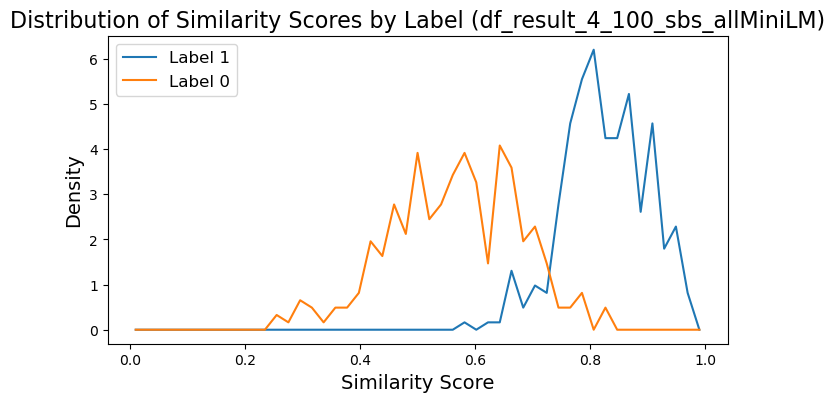

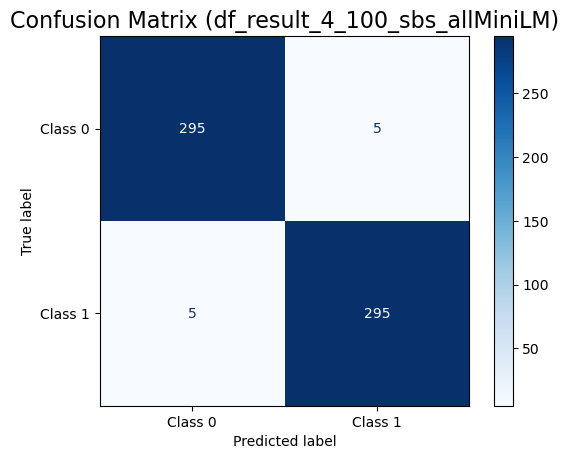


Performance Metrics:
           df_result_4_100_sbs_allMiniLM
Accuracy                        0.983333
Precision                       0.983333
Recall                          0.983333
F1-Score                        0.983333


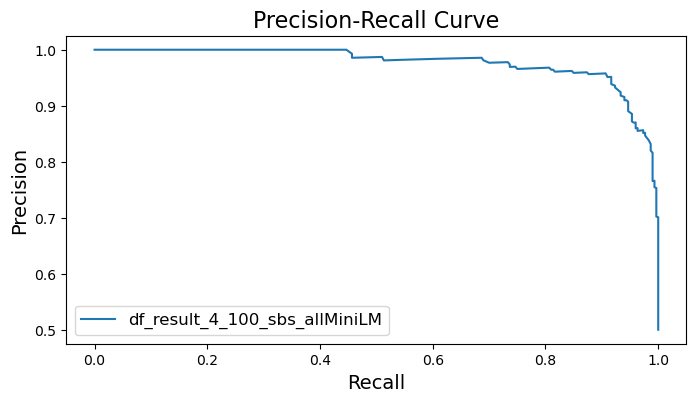

In [100]:
performance_analysis(df_result_4_100_sbs_allMiniLM)

### 2.3.3 NV-Embed-v2

**Dataset Specs:**
- 100 JDs a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Skill-by-skill
- NV-Embed-v2

**"NV-Embed-v2" Model Characteristics:**
- Model size: 
- Embedding dimensions: 
- Tokenizer:
- Memory Usage (GB, fp32): 
- Max Tokens: 

#### 2.3.3.1 Function for running the Model

In [4]:
import time

def main_synth_sbs_NV_Embed_v2_df(synth_data):
    t0 = time.time()

    # Initialize an empty list to store results
    similarity_results = []

    # Iterate over each unique job description ID in the dataset
    for jd_id in synth_data['JD_ID'].unique():
        # Filter the data for the current job description
        job_data = synth_data[synth_data['JD_ID'] == jd_id]

        # Extract the job description text
        jd_text = job_data.iloc[0]['JD_text']
        df_jobs = pd.DataFrame([jd_text], columns=["raw"])
        df_jobs = job_info_extraction(df_jobs)  # Extract job description skills
        df_jobs = df_jobs.reset_index(drop=True)  # Ensure consistent indexing
        
        # Extract resumes for this job description
        resumes = job_data[['CV_ID', 'CV_text']].copy()
        resumes['name'] = resumes['CV_ID']
        resumes['raw'] = resumes['CV_text']
        df_resumes = resume_extraction(resumes)
        df_resumes = df_resumes.reset_index(drop=True)  # Ensure consistent indexing

        # Ensure the Skills column exists
        if 'Skills' not in df_jobs.columns or 'Skills' not in df_resumes.columns:
            raise ValueError("The 'Skills' column is missing in one of the extracted DataFrames.")
        
        # Calculate similarity for the job description and its related resumes
        analysis_data_df = calc_similarity_sbs_NV_Embed_v2(df_resumes, df_jobs)
        
        # Add similarity scores back to the original data
        job_data = job_data.reset_index(drop=True)
        job_data['Similarity_score'] = analysis_data_df['nvidia/NV-Embed-v2_score']

        # Append to results
        similarity_results.append(job_data)

    # Combine all results into a single DataFrame
    df_final = pd.concat(similarity_results, ignore_index=True)

    t1 = time.time()
    dt = t1 - t0
    print(f"Processing Time: {dt*1000:.2f}ms")
    
    return df_final

#### 2.3.3.2 Running the Model

In [ ]:
df_result_4_100_sbs_NVEmbed = main_synth_sbs_NV_Embed_v2_df(df_synth_data_3_test)

df_result_4_100_sbs_NVEmbed.head(3)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

1_Pooling/config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<div style="background-color: #fff4e5; border-left: 6px solid #ff4500; padding: 10px; font-size: 16px;">
    The Model was to computationally intensive, even with the smaller dataset with 20 JDs.
</div>

### 2.3.4 BinGSE-Meta-Llama-3-8B-Instruct

**Dataset Specs:**
- 100 JDs a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Skill-by-skill
- BinGSE-Meta-Llama-3-8B-Instruct

**"BinGSE-Meta-Llama-3-8B-Instruct" Model Characteristics:**
- Model size: 
- Embedding dimensions: 
- Tokenizer:
- Memory Usage (GB, fp32): 
- Max Tokens: 

#### 2.3.4.1 main_synth_sbs_Llama_df function for running the Model

In [4]:
import time
import torch

def main_synth_sbs_BinGSE_MetaLlama_3_8B_Instruct_df(synth_data):
    t0 = time.time()

    # Initialize an empty list to store results
    similarity_results = []

    # Iterate over each unique job description ID in the dataset
    for jd_id in synth_data['JD_ID'].unique():
        # Filter the data for the current job description
        job_data = synth_data[synth_data['JD_ID'] == jd_id]

        # Extract the job description text
        jd_text = job_data.iloc[0]['JD_text']
        df_jobs = pd.DataFrame([jd_text], columns=["raw"])
        df_jobs = job_info_extraction(df_jobs)  # Extract job description skills
        df_jobs = df_jobs.reset_index(drop=True)  # Ensure consistent indexing

        # Extract resumes for this job description
        resumes = job_data[['CV_ID', 'CV_text']].copy()
        resumes['name'] = resumes['CV_ID']
        resumes['raw'] = resumes['CV_text']
        df_resumes = resume_extraction(resumes)
        df_resumes = df_resumes.reset_index(drop=True)  # Ensure consistent indexing

        # Ensure the Skills column exists
        if 'Skills' not in df_jobs.columns or 'Skills' not in df_resumes.columns:
            raise ValueError("The 'Skills' column is missing in one of the extracted DataFrames.")
        
        # Calculate similarity for the job description and its related resumes
        analysis_data_df = calc_similarity_sbs_BinGSE_MetaLlama_3_8B_Instruct(df_resumes, df_jobs)
        
        # Add similarity scores back to the original data
        job_data = job_data.reset_index(drop=True)
        job_data['Similarity_score'] = analysis_data_df['BinGSE-Meta-Llama-3-8B-Instruct_score']

        # Append to results
        similarity_results.append(job_data)

    # Combine all results into a single DataFrame
    df_final = pd.concat(similarity_results, ignore_index=True)

    t1 = time.time()
    dt = t1 - t0
    print(f"Processing Time: {dt*1000:.2f}ms")
    
    return df_final

#### 2.3.4.2 Running the Model

In [ ]:
# !pip install accelerate

In [ ]:
# !pip install --upgrade accelerate

#### Running a Test

In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModel
from peft import PeftModel
import torch  # Add this line

tokenizer = AutoTokenizer.from_pretrained("McGill-NLP/LLM2Vec-Meta-Llama-3-8B-Instruct-mntp")
config = AutoConfig.from_pretrained("McGill-NLP/LLM2Vec-Meta-Llama-3-8B-Instruct-mntp", trust_remote_code=True)

base_model = AutoModel.from_pretrained(
    "McGill-NLP/LLM2Vec-Meta-Llama-3-8B-Instruct-mntp",
    trust_remote_code=True,
    config=config,
    torch_dtype=torch.bfloat16,
    device_map="cuda" if torch.cuda.is_available() else "cpu",
)

print("Base model loaded successfully.")

peft_model = PeftModel.from_pretrained(
    base_model, 
    "McGill-NLP/LLM2Vec-Meta-Llama-3-8B-Instruct-mntp"
)

print("PEFT model loaded successfully.")

#### Waiting for Access Approval

In [ ]:
df_result_4_100_sbs_Llama = main_synth_sbs_BinGSE_MetaLlama_3_8B_Instruct_df(df_synth_data_4_100)

df_result_4_100_sbs_Llama.head(3)

In [ ]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result_4_100_sbs_Llama = df_result_4_100_sbs_Llama.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result_4_100_sbs_Llama['label_predicted'] = df_result_4_100_sbs_Llama.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result_4_100_sbs_Llama

In [ ]:
performance_analysis(df_result_4_100_sbs_Llama)

### 2.3.5 voyage-large-2-instruct

**Dataset Specs:**
- 100 JDs a 6 CVs
- "almost perfect fit" vs. "slightly bad to moderate fit"

**Model Specs:**
- Skill-by-skill
- voyage-large-2-instruct

**"voyage-large-2-instruct" Model Characteristics:**
- Model size: 
- Embedding dimensions: 
- Tokenizer:
- Memory Usage (GB, fp32): 
- Max Tokens: 

In [ ]:
import torch
from sentence_transformers import SentenceTransformer

# In main.py and imported into the Notebook
def calc_similarity(applicant_df, job_df, N=3, parallel=False):
    """Calculate cosine similarity based on NV-Embed-v2 embeddings of combined skills."""

    '''# Initialize the model once outside the loop for efficiency
    model = SentenceTransformer('nvidia/NV-Embed-v2', trust_remote_code=True)
    model.max_seq_length = 75
    model.tokenizer.padding_side="right"'''

    def add_eos(input_examples):
        """ helper function to add special tokens between each skills"""
        input_examples = [input_example + model.tokenizer.eos_token for input_example in input_examples]
        return input_examples

    # Precompute job embeddings
    job_df['Skills_Text'] = job_df['Skills'].apply(add_eos)
    job_df['Skills_Text'] = job_df['Skills_Text'].apply(lambda x: ' '.join(sorted(set(x))) if isinstance(x, list) else '')
    job_embeddings = model.encode(
    job_df['Skills_Text'].tolist())
    # Precompute applicant embeddings
    applicant_df['Skills_Text'] = applicant_df['Skills'].apply(add_eos)
    applicant_df['Skills_Text'] = applicant_df['Skills_Text'].apply(lambda x: ' '.join(sorted(set(x))) if isinstance(x, list) else '')
    applicant_embeddings = model.encode(
    applicant_df['Skills_Text'].tolist(),
        batch_size=32,
        num_workers=os.cpu_count() // 2 if parallel else 0,
        show_progress_bar=False
    )

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(job_embeddings, applicant_embeddings)

    # Create a DataFrame from the similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix.T, index=applicant_df['name'], columns=job_df.index)
    similarity_df = similarity_df.reset_index().melt(id_vars='name', var_name='job_id', value_name='similarity_score')
    similarity_df['rank'] = similarity_df.groupby('job_id')['similarity_score'].rank(ascending=False)
    similarity_df['interview_status'] = similarity_df['rank'].apply(lambda x: 'Selected' if x <= N else 'Not Selected')

    return similarity_df

### 2.3.5 SFR-Embedding-Mistral

**Model Characteristics:**
- Model size: 
- Embedding dimensions: 
- Tokenizer:
- Memory Usage (GB, fp32): 
- Max Tokens: 

## 2.4 Modelling Approach: Bi-Encoder (baseline) vs. Cross-Encoder

In [ ]:
# Victors Code for Cross-Encoder

# Necessary imports
from sentence_transformers import SentenceTransformer, CrossEncoder
import torch
import torch.nn.functional as F

# Similarity Calculation using Cross-Encoder
def calc_cross(applicant_df, job_df, N=3, parallel=False):
    """ Use Cross Encoder to calculate similarity of combined skills."""

    # Initialize the model once outside the loop for efficiency
    model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

     # Precompute job embeddings
    job_df['Skills_Text'] = job_df['Skills'].apply(lambda x: ' '.join(sorted(set(x))) if isinstance(x, list) else '')
    query = job_df['Skills_Text'][0]
    # Precompute applicant embeddings
    applicant_df['Skills_Text'] = applicant_df['Skills'].apply(lambda x: ' '.join(sorted(set(x))) if isinstance(x, list) else '')
    applicants = applicant_df['Skills_Text'].tolist()

    ranks = model.rank(
        query,
        applicants,
        batch_size=32,
        num_workers=os.cpu_count() // 2 if parallel else 0,
        show_progress_bar=False
    )

    similarity_df = pd.DataFrame(ranks)
    similarity_df['softmaxed'] = F.softmax(torch.tensor(similarity_df['score']))
    similarity_df = similarity_df.join(applicant_df[["name"]], on="corpus_id")
    
    # similarity_df['interview_status'] = similarity_df.index.apply(lambda x: 'Selected' if x <= N else 'Not Selected')

    return similarity_df